In [ ]:
import os
import sys
sys.path.insert(0, '../')
import torch
import numpy as np
import trimesh
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from einops import rearrange

In [2]:
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass
import ipywidgets as widgets

widgets.HTML("""
<style>
.jupyter-widget-colortag {
    height: 50px;
}
.jupyter-widget-colortag i {
    margin-left: 50px;
}
</style>
""")

HTML(value='\n<style>\n.jupyter-widget-colortag {\n    height: 50px;\n}\n.jupyter-widget-colortag i {\n    mar…

In [3]:
from data import dataset_dict
from utils.color import sort_palette, rgb2hex, hex2rgb
from utils.vis import plot_palette_colors
from utils.palette_utils.Additive_mixing_layers_extraction import Hull_Simplification_determined_version

## Utils

In [4]:
dir_basename = lambda s: os.path.basename(os.path.normpath(s))

def save_palette(dir, p, suffix=''):
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    path = os.path.join(dir, f'rgb_palette{"_" + suffix if suffix else ""}.npy')
    if os.path.exists(path):
        print(f'CANNOT save palette: {path} exists')
        return
    
    np.save(path, p)
    print('Save palette to', path)

## Load Data

In [5]:
dataset_type = 'blender'
datadir = '/root/autodl-tmp/nerf_data/nerf_synthetic/chair'
outdir = os.path.join('../data_palette/', dir_basename(datadir))

dataset = dataset_dict[dataset_type](datadir, split='train', downsample=8.0 if dataset_type == 'llff' else 1.0, is_stack=False)
w, h = dataset.img_wh[0], dataset.img_wh[1]
rgbs = dataset.all_rgbs
print(w)
print(h)
print(rgbs)
fg = None
if dataset.white_bg:
    fg = torch.lt(rgbs, 1.).any(dim=-1)
    rgbs = rgbs[fg]
    print(rgbs)
rgbs = rgbs.to(device='cpu', dtype=torch.double).numpy()

Loading data train (100): 100%|██████████| 100/100 [00:02<00:00, 49.18it/s]


800
800
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.9961, 0.9961, 0.9961],
        [1.0000, 1.0000, 0.9994],
        [0.9940, 0.9910, 0.9870],
        ...,
        [0.9964, 1.0000, 1.0000],
        [0.9985, 0.9996, 1.0000],
        [0.9976, 0.9975, 0.9975]])


In [6]:
rgbs.shape

(13003178, 3)

## Create Palette

In [7]:
error_thres = 2. / 256.
# error_thres = 1. / 500.
palette = Hull_Simplification_determined_version(rgbs[:w*h, ...], '', error_thres=error_thres)

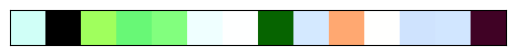

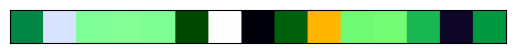

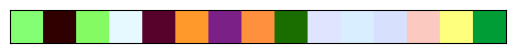

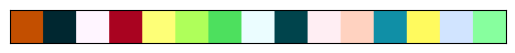

In [8]:
# Run this cell to view all color convex hull vertices
hull = ConvexHull(rgbs)
hull_vertices = hull.points[hull.vertices]
split_chunk_indices = np.linspace(0, len(hull_vertices), len(hull_vertices) // 10, dtype=int)
split_chunk_indices = split_chunk_indices[1:-1]
for hull_vtx_chunk in np.array_split(hull_vertices, split_chunk_indices):
    plot_palette_colors(hull_vtx_chunk)

In [9]:
# Use this color picker if you want to pick a color among the convex hull vertices
widgets.ColorPicker(concise=False, description=f'Pick a color', value='#000000', disabled=False)

ColorPicker(value='#000000', description='Pick a color')

Original palette


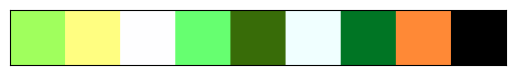

In [10]:
print('Original palette')
plot_palette_colors(palette)

palette_sorted = palette

In [11]:
print('Drag to sort the colors in the palette')

hex_palette = [rgb2hex(c) for c in palette_sorted]

color_tags = widgets.ColorsInput(value=hex_palette)
color_tags

Drag to sort the colors in the palette


ColorsInput(value=['#a0ff5d', '#ffff82', '#ffffff', '#67ff71', '#396c09', '#f1ffff', '#007525', '#ff8936', '#0…

In [12]:
print(hex_palette)

['#a0ff5d', '#ffff82', '#ffffff', '#67ff71', '#396c09', '#f1ffff', '#007525', '#ff8936', '#000000']


Sorted palette


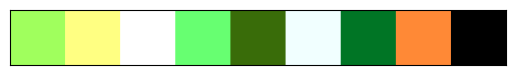

In [13]:
palette_sorted = np.array([hex2rgb(cl) for cl in color_tags.value]).astype(np.float32) / 255.
print('Sorted palette')
plot_palette_colors(palette_sorted)

In [14]:
print(palette_sorted)

[[0.627451   1.         0.3647059 ]
 [1.         1.         0.50980395]
 [1.         1.         1.        ]
 [0.40392157 1.         0.44313726]
 [0.22352941 0.42352942 0.03529412]
 [0.94509804 1.         1.        ]
 [0.         0.45882353 0.14509805]
 [1.         0.5372549  0.21176471]
 [0.         0.         0.        ]]


In [15]:
save_palette(outdir, palette_sorted)

CANNOT save palette: ../data_palette/chair/rgb_palette.npy exists


## Visualization

This section provides a very simple visualization tool, where you can roughly view the distribution of picked palette colors on input images.

In [16]:
def sort_palette_w_vis(rgbs, palette_rgb, dataset=None, fg=None, plt_vote_map_idx=0,):
    
    '''像素颜色属于哪个调色板'''
    dist = rearrange(rgbs, 'N C -> N 1 C') - rearrange(palette_rgb, 'P C -> 1 P C')
    dist = np.linalg.norm(dist, axis=-1) #2范数  相当于求像素间距离
    dist = np.argmin(dist, axis=-1)
    
    
    
    if dataset is not None and dataset.white_bg and fg is not None:
        all_rgb_cp = dataset.all_rgbs.clone().cpu().numpy()
    else:
        all_rgb_cp = rgbs.copy()
    all_rgb_maps = all_rgb_cp.reshape(-1, h, w, 3)

    # Show palette voting of pixels 
    palette_vote = palette_rgb[dist]
    if fg is not None:
        palette_vote_maps = all_rgb_cp.copy()
        palette_vote_maps[fg] = palette_vote
    else:
        palette_vote_maps = palette_vote
    palette_vote_maps = palette_vote_maps.reshape(-1, h, w, 3)
    print(palette_vote_maps.shape)
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(all_rgb_maps[plt_vote_map_idx])
    axes[1].imshow(palette_vote_maps[plt_vote_map_idx])
    
    
    
    dist = np.bincount(dist)
    
    
    
    # Show palette distribution
    plt.figure()
    plt.bar(np.arange(0, len(palette_rgb)), dist, color=palette_rgb, edgecolor='black')
    
    
    
    dist = np.argsort(dist)

    # bg = np.ones(3) if dataset.white_bg else np.zeros(3)
    # palette_rgb = [tuple(a.tolist()) for a in palette_rgb[dist.cpu().numpy()] if not np.allclose(a, bg)]
    # palette_rgb.append(tuple(bg.tolist()))
    palette_rgb = [tuple(a) for a in palette_rgb[dist].tolist()]
    return np.array(palette_rgb)


In [17]:
from utils.color_decomposition import color_decomposition
def plot_color_decomposition(rgbs,palette_rgb,plot_palette_color_idx=1,dataset=None,fg=None):
    rgbs = torch.tensor(rgbs)
    palette_rgb = torch.tensor(palette_rgb)
    palette_number = palette_rgb.shape[0]
    color_deco = color_decomposition(rgbs,palette_rgb) # bs * h * w
    if dataset is not None and dataset.white_bg and fg is not None:
        all_rgb_cp = dataset.all_rgbs.clone().cpu()
        all_rgb_cp_original = dataset.all_rgbs.clone().cpu()
    else:
        all_rgb_cp = torch.clone(rgbs)
        all_rgb_cp_original = torch.clone(rgbs)
        
    true_idx = (color_deco != plot_palette_color_idx) # bs * 1
    fg[fg==True] = true_idx
    
    all_rgb_cp[fg] = 1.
    
    all_rgb_maps = torch.reshape(all_rgb_cp,(-1, h, w, 3))
    all_rgb_cp_original = torch.reshape(all_rgb_cp_original,(-1,h,w,3))
    
    
    
    
    fig,axes = plt.subplots(1,2)
    axes[0].imshow(all_rgb_maps[plot_palette_color_idx].clone().numpy())
    axes[1].imshow(all_rgb_cp_original[plot_palette_color_idx].clone().numpy())

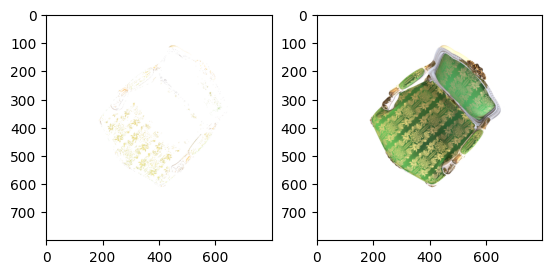

In [18]:
plot_color_decomposition(rgbs,palette_sorted,dataset=dataset,fg=fg)

In [19]:
widgets.ColorPicker(concise=False, description=f'Pick a color', value='#000000', disabled=False)

ColorPicker(value='#000000', description='Pick a color')

In [20]:
# Run this cell to visualize 1-nn color distribution

palette_sorted_ = sort_palette_w_vis(rgbs, palette_sorted, dataset=dataset, fg=fg, plt_vote_map_idx=1)
plot_palette_colors(palette_sorted_)

ValueError: shape mismatch: value array of shape (13003178,3) could not be broadcast to indexing result of shape (9869416,3)